# Flying insect activity-levels analysis
This notebook demonstrates analysis of flying insect activity levels data from camfi.

First, load the required libraries.

In [1]:
from datetime import datetime, timedelta, timezone
import itertools
import textwrap

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

from camfi.projectconfig import CamfiConfig
from camfi.plotting.matplotlib import (
    plot_activity_levels_summary,
    plot_activity_levels_summaries,
    plot_maelstroms_with_temperature,
)

Next, load the image metadata (including annotations from VIA). This file should have the corrected image capture timestamps (refer to the Wingbeat Analysis notebook).

In [2]:
config_path = "data/cabramurra_config.json"

config = CamfiConfig.parse_file(config_path)

# We can print out our config using config.json()
print(config.json(exclude_unset=True, indent=2))

{
  "root": null,
  "via_project_file": "data/cabramurra_all_annotations.json",
  "day_zero": "2019-01-01",
  "output_tz": "+10:00",
  "time": {
    "camera_placements": {
      "2019-11_cabramurra/0001": {
        "camera_start_time": "2019-11-14T13:00:00+11:00",
        "location": "cabramurra"
      },
      "2019-11_cabramurra/0002": {
        "camera_start_time": "2019-11-14T13:00:00+11:00",
        "location": "cabramurra"
      },
      "2019-11_cabramurra/0003": {
        "camera_start_time": "2019-11-14T13:00:00+11:00",
        "location": "cabramurra"
      },
      "2019-11_cabramurra/0004": {
        "camera_start_time": "2019-10-14T13:00:00+11:00",
        "actual_start_time": "2019-11-14T13:00:00+11:00",
        "location": "cabramurra"
      },
      "2019-11_cabramurra/0005": {
        "camera_start_time": "2019-11-14T13:00:00+11:00",
        "location": "cabramurra"
      },
      "2019-11_cabramurra/0006": {
        "camera_start_time": "2019-11-14T13:00:00+11:00",
  

For the following analyses, we need a Pandas DataFrame. The folowwing command builds a dataframe with an entry for each image, with data taken from sources specified in the config. We will also convert all the `datetime_corrected` values to AEST (+10:00, set in config file) - in our data they are in AEDT (+11:00).

In [3]:
df = config.get_merged_dataframe()
df

img_key  \
location   date                                                 
cabramurra 2019-11-14  2019-11_cabramurra/0001/DSCF0001.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0002.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0003.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0004.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0005.JPG-1   
...                                                       ...   
           2019-11-26  2019-11_cabramurra/0010/DSCF0860.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0861.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0862.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0863.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0864.JPG-1   

                                                   filename  n_annotations  \
location   date                                                              
cabramurra 2019-11-14  2019-11_cabramurra/0001/DSCF0001.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0002.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0003.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0004.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0005.JPG              0   
...                                                     ...            ...   
           2019-11-26  2019-11_cabramurra/0010/DSCF0860.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0861.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0862.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0863.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0864.JPG              0   

                             datetime_corrected   datetime_original  \
location   date                                                       
cabramurra 2019-11-14 2019-11-14 18:00:03+10:00 2019-11-14 19:00:03   
           2019-11-14 2019-11-14 18:10:06+10:00 2019-11-14 19:10:06   
           2019-11-14 2019-11-14 18:20:09+10:00 2019-11-14 19:20:09   
           2019-11-14 2019-11-14 18:30:11+10:00 2019-11-14 19:30:11   
           2019-11-14 2019-11-14 18:40:14+10:00 2019-11-14 19:40:14   
...                                         ...                 ...   
           2019-11-26 2019-11-26 05:13:26+10:00 2019-11-26 06:13:26   
           2019-11-26 2019-11-26 05:23:29+10:00 2019-11-26 06:23:29   
           2019-11-26 2019-11-26 05:33:31+10:00 2019-11-26 06:33:31   
           2019-11-26 2019-11-26 05:43:34+10:00 2019-11-26 06:43:34   
           2019-11-26 2019-11-26 05:53:37+10:00 2019-11-26 06:53:37   

                       exposure_time  pixel_x_dimension  pixel_y_dimension  \
location   date                                                              
cabramurra 2019-11-14       0.012048               4608               3456   
           2019-11-14       0.009174               4608               3456   
           2019-11-14       0.012048               4608               3456   
           2019-11-14       0.020833               4608               3456   
           2019-11-14       0.033333               4608               3456   
...                              ...                ...                ...   
           2019-11-26       0.033333               4608               3456   
           2019-11-26       0.033333               4608               3456   
           2019-11-26       0.023810               4608               3456   
           2019-11-26       0.018182               4608               3456   
           2019-11-26       0.013889               4608               3456   

                           astronomical_twilight_start  \
location   date                                          
cabramurra 2019-11-14 2019-11-14 03:12:20.886936+10:00   
           2019-11-14 2019-11-14 03:12:20.886936+10:00   
           2019-11-14 

To get a general overview of the activity levels observed throughout the study period, we pool the data from all cameras and plot the number of annotations per 10-minute interval:

In [4]:
# Setting frame of reference and
# adding a daynumber column to df, for simpler plots
df["daynumber"] = (
    df["datetime_corrected"] - config.timestamp_zero
).dt.total_seconds() / 86400

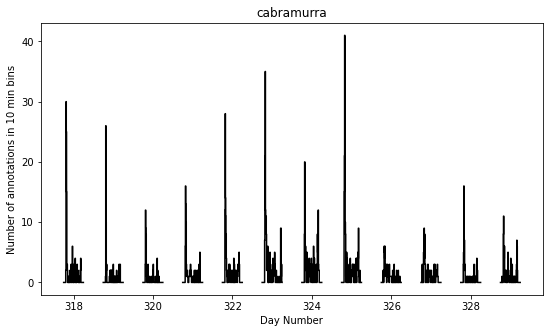

In [5]:
location_names = [location.name for location in config.place.locations]
fig = plot_activity_levels_summaries(
    df,
    location_names,
    x_column="daynumber",
    bin_width=10 / 1440,   # 10 minutes
    ax_kwargs=dict(
        ylabel="Number of annotations in 10 min bins",
        xlabel="Day Number"
    ),
    c="k",
)

The gaps in the above figure are periods where the cameras were not set to take photos (they were only set to take photos between the hours of 19:00-07:00 AEDT each night).

There seems to be a periodic signal in the data, with more activity in the evening. We can take a closer look at this by pooling the data from all days into a single representative 24-hour period.

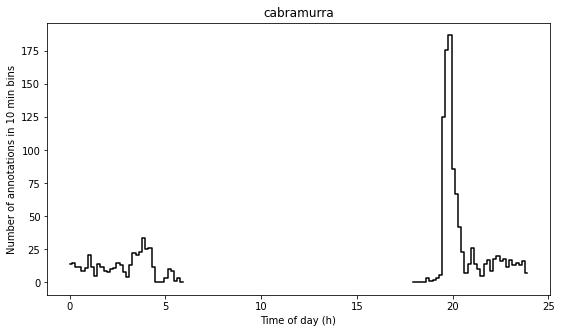

In [6]:
df["dayhour"] = (df["daynumber"] - np.floor(df["daynumber"])) * 24.

fig = plot_activity_levels_summaries(
    df,
    location_names,
    x_column="dayhour",
    bin_width=10 / 60,   # 10 minutes
    ax_kwargs=dict(
        ylabel="Number of annotations in 10 min bins",
        xlabel="Time of day (h)"
    ),
    c="k",
)

In the above figure we see a striking increase in activity levels during the hours of 19:20-20:20. This seems to be when the most insects are flying.

Instead of binning this data by absolute time of day, it would be nice to bin it according to the relative time from astronomical events, eg. sunset.

Here we calculate a "within_twilight" column, which is time after sunset, scaled to the duration of twilight. We'll also calculate a "daylight_hours" column, which will be used later.

In [7]:
df["within_twilight"] = (
    df["datetime_corrected"] - df["sunset"]
) / (
    df["astronomical_twilight_end"] - df["sunset"]
) 
df["daylight_hours"] = (df["sunset"] - df["sunrise"]).dt.total_seconds() / 3600

df

img_key  \
location   date                                                 
cabramurra 2019-11-14  2019-11_cabramurra/0001/DSCF0001.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0002.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0003.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0004.JPG-1   
           2019-11-14  2019-11_cabramurra/0001/DSCF0005.JPG-1   
...                                                       ...   
           2019-11-26  2019-11_cabramurra/0010/DSCF0860.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0861.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0862.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0863.JPG-1   
           2019-11-26  2019-11_cabramurra/0010/DSCF0864.JPG-1   

                                                   filename  n_annotations  \
location   date                                                              
cabramurra 2019-11-14  2019-11_cabramurra/0001/DSCF0001.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0002.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0003.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0004.JPG              0   
           2019-11-14  2019-11_cabramurra/0001/DSCF0005.JPG              0   
...                                                     ...            ...   
           2019-11-26  2019-11_cabramurra/0010/DSCF0860.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0861.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0862.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0863.JPG              0   
           2019-11-26  2019-11_cabramurra/0010/DSCF0864.JPG              0   

                             datetime_corrected   datetime_original  \
location   date                                                       
cabramurra 2019-11-14 2019-11-14 18:00:03+10:00 2019-11-14 19:00:03   
           2019-11-14 2019-11-14 18:10:06+10:00 2019-11-14 19:10:06   
           2019-11-14 2019-11-14 18:20:09+10:00 2019-11-14 19:20:09   
           2019-11-14 2019-11-14 18:30:11+10:00 2019-11-14 19:30:11   
           2019-11-14 2019-11-14 18:40:14+10:00 2019-11-14 19:40:14   
...                                         ...                 ...   
           2019-11-26 2019-11-26 05:13:26+10:00 2019-11-26 06:13:26   
           2019-11-26 2019-11-26 05:23:29+10:00 2019-11-26 06:23:29   
           2019-11-26 2019-11-26 05:33:31+10:00 2019-11-26 06:33:31   
           2019-11-26 2019-11-26 05:43:34+10:00 2019-11-26 06:43:34   
           2019-11-26 2019-11-26 05:53:37+10:00 2019-11-26 06:53:37   

                       exposure_time  pixel_x_dimension  pixel_y_dimension  \
location   date                                                              
cabramurra 2019-11-14       0.012048               4608               3456   
           2019-11-14       0.009174               4608               3456   
           2019-11-14       0.012048               4608               3456   
           2019-11-14       0.020833               4608               3456   
           2019-11-14       0.033333               4608               3456   
...                              ...                ...                ...   
           2019-11-26       0.033333               4608               3456   
           2019-11-26       0.033333               4608               3456   
           2019-11-26       0.023810               4608               3456   
           2019-11-26       0.018182               4608               3456   
           2019-11-26       0.013889               4608               3456   

                           astronomical_twilight_start  \
location   date                                          
cabramurra 2019-11-14 2019-11-14 03:12:20.886936+10:00   
           2019-11-14 2019-11-14 03:12:20.886936+10:00   
           2019-11-14 

We can now plot these data. This also plots a separate trace for each location (whereas the above plot only plots one trace for all the data).

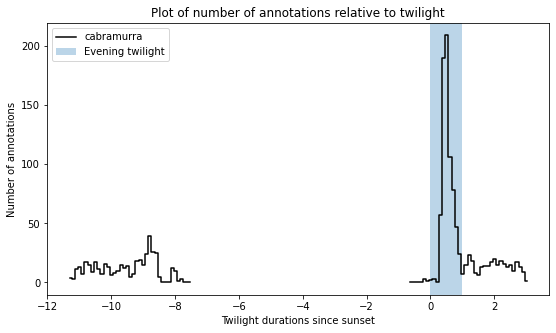

In [8]:
fig = plot_activity_levels_summaries(
    df,
    location_names,
    x_column="within_twilight",
    bin_width=0.1,   # 10th of twilight duration
    ax_kwargs=dict(
        title="Plot of number of annotations relative to twilight",
        ylabel="Number of annotations",
        xlabel="Twilight durations since sunset"
    ),
    separate_plots=False,
    c="k",
)
twilight_vspan = fig.axes[0].axvspan(0, 1, alpha=0.3, label="Evening twilight")
legend = fig.axes[0].legend()

The moths appear to be flying during twilight. So lets select only those time points to quantify daily maelstrom intensity. Taking the sum of annotations during this period for each day, we can then look at how activity levels were across the days of the study period.

In [9]:
# We're only interested in the numeric columns
keep_dtypes = set(
    np.dtype("".join(t)) for t in itertools.product("ifu", "248")
)
keep_cols = filter(lambda c: df[c].dtype in keep_dtypes, df.columns)

# But even some of the numeric columns are irrelevant after aggregation
drop_cols = {
    "exposure_time",
    "pixel_x_dimension",
    "pixel_y_dimension",
    "dayhour",
    "within_twilight",
}
keep_cols = filter(lambda c: c not in drop_cols, keep_cols)

# For most of the columns, we just want to take the mean value
aggregation_functions = {column: (column, "mean") for column in keep_cols}

# But for "n_annotations", we want to take the sum
aggregation_functions["n_annotations"] = ("n_annotations", "sum")

# And we want to truncate "daynumber" to an integer
aggregation_functions["daynumber"] = ("daynumber", lambda x: int(x[0]))

# We also want to make a new column with the exposure (number of images
# taken) during each twilight interval.
aggregation_functions["exposures"] = ("n_annotations", "count")

# Now we select the data which was obtained during twilight,
# and group it by location and date, aggregating using the above-defined
# aggregation functions. This leaves us with a DataFrame with one row per
# date for each location in the study.
maelstrom_df = df[
    (df["within_twilight"] <= 1.) & (df["within_twilight"] >= 0)
].groupby(["location", "date"]).aggregate(**aggregation_functions)
maelstrom_df

n_annotations  temperature_minimum_degC  \
location   date                                                  
cabramurra 2019-11-14             80                      -0.6   
           2019-11-15             42                       4.7   
           2019-11-16             35                       3.7   
           2019-11-17             50                       3.3   
           2019-11-18             79                       4.5   
           2019-11-19            105                       7.5   
           2019-11-20             59                      11.0   
           2019-11-21            117                      15.0   
           2019-11-22             33                      17.2   
           2019-11-23             40                      11.3   
           2019-11-24             43                       8.2   
           2019-11-25             36                      11.8   

                       temperature_minimum_evening_degC  \
location   date                                           
cabramurra 2019-11-14                               4.7   
           2019-11-15                               3.7   
           2019-11-16                               3.3   
           2019-11-17                               4.5   
           2019-11-18                               7.5   
           2019-11-19                              11.0   
           2019-11-20                              15.0   
           2019-11-21                              17.2   
           2019-11-22                              11.3   
           2019-11-23                               8.2   
           2019-11-24                              11.8   
           2019-11-25                              13.0   

                       temperature_maximum_degC  rainfall_mm  \
location   date                                                
cabramurra 2019-11-14                      12.3          0.0   
           2019-11-15                      13.8          0.0   
           2019-11-16                      14.3          0.0   
           2019-11-17                      14.3          0.0   
           2019-11-18                      16.0          0.0   
           2019-11-19                      21.7          0.0   
           2019-11-20                      23.1          0.0   
           2019-11-21                      27.6          0.0   
           2019-11-22                      22.6          0.0   
           2019-11-23                      20.0          0.0   
           2019-11-24                      19.8          0.0   
           2019-11-25                      21.9          0.0   

                       maximum_wind_gust_speed_kph  temperature_9am_degC  \
location   date                                                            
cabramurra 2019-11-14                         41.0                   4.9   
           2019-11-15                         70.0                   8.3   
           2019-11-16                         48.0                   5.9   
           2019-11-17                         33.0                   8.4   
           2019-11-18                         43.0                   7.6   
           2019-11-19                         65.0                  13.0   
           2019-11-20                         31.0                  15.0   
           2019-11-21                         50.0                  22.0   
           2019-11-22                         54.0                  19.8   
           2019-11-23                         43.0                  13.9   
           2019-11-24                         41.0                  13.0   
           2019-11-25                         50.0                  13.9   

                       relative_humidity_9am_pc  cloud_amount_9am_oktas  \
location   date                                                           
cabramurra 2019-11-14                      95.0                     3.0   
           2019-11-15                      73.0                     2.0   
         

Now we can plot these data:

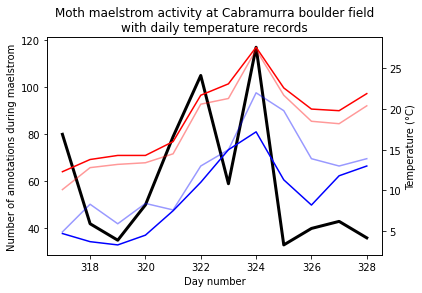

In [10]:
fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Moth maelstrom activity at Cabramurra boulder field\nwith daily temperature records",
    ylabel="Number of annotations during maelstrom",
    xlabel="Day number",
)
lines = plot_maelstroms_with_temperature(
    maelstrom_df,
    ax,
    maelstrom_kwargs=dict(
        c="k",
        lw=3,
    ),
)

We then may like to regress the activity levels against various factors. Given the activity level count data, we can proceed using a Poisson regression of `n_annotations` vs. the independent variables of interest.

First, we will select non-correlated covariates from `maelstrom_df`. Here we can add derived covariates, such as `temperature_range` and `dewpoint_degC`.

We also define a set `drop` of columns not to include as covariates.

In [11]:
maelstrom_df["temperature_range"] = maelstrom_df.temperature_maximum_degC - maelstrom_df.temperature_minimum_evening_degC
# maelstrom_df["dewpoint_3pm_degC"] = mpcalc.dewpoint_from_relative_humidity(
#     units.Quantity(maelstrom_df["temperature_3pm_degC"].array, "degC"),
#     units.Quantity(maelstrom_df["relative_humidity_3pm_pc"].array, "percent"),
# )

drop = {
    "n_annotations",           # Variable of interest
    "rainfall_mm",             # All zero in this dataset
    "cloud_amount_9am_oktas",  # Hass missing data
    "exposures",               # Exposure variable
}
covariates = list(filter(lambda c: c not in drop, maelstrom_df.columns))

We can then plot scatter plots of all of the covariates.

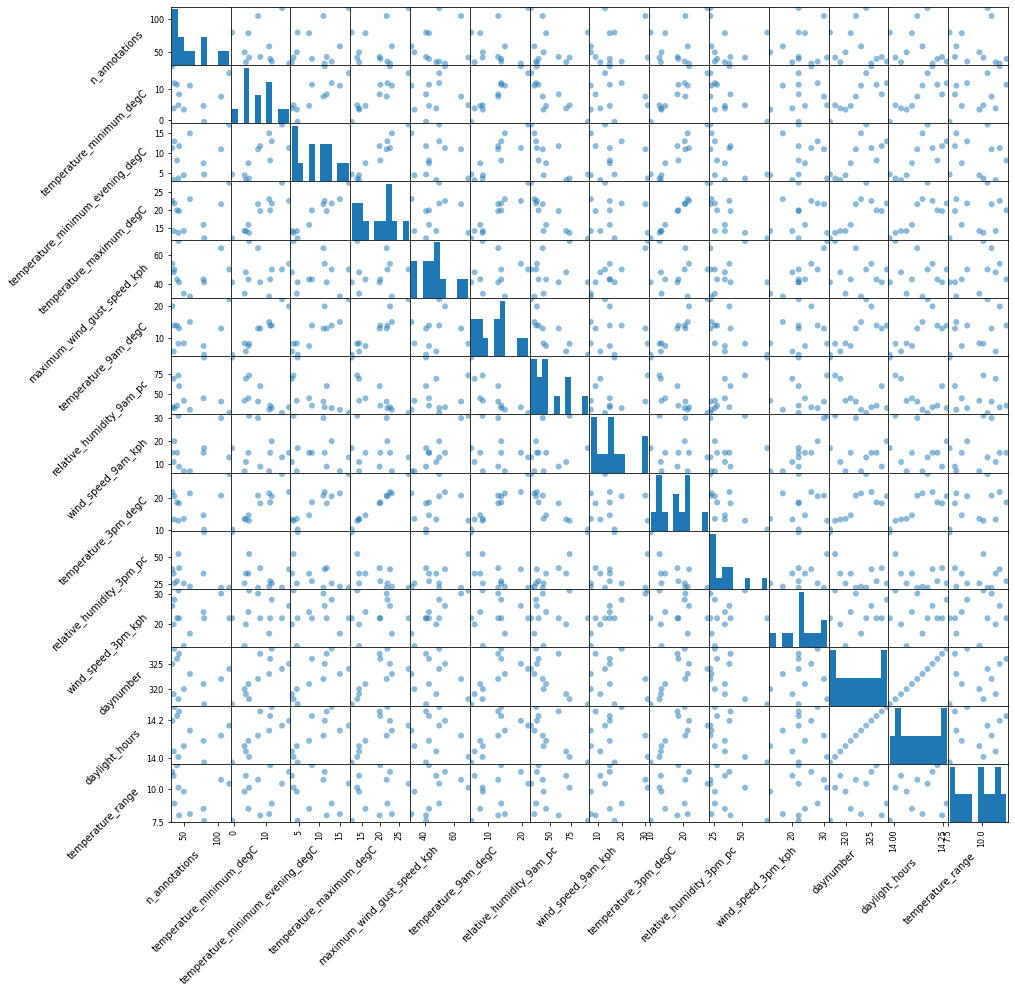

In [12]:
grr = pd.plotting.scatter_matrix(
    maelstrom_df[["n_annotations", *covariates]],
    marker="o",
    figsize=(15, 15),
)
for ax in grr[-1, :]:
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha="right")
for ax in grr[:, 0]:
    ax.set_ylabel(ax.get_ylabel(), rotation=45, ha="right")

Some of these look like they are correlated, so we should remove them from the list of covariates. We start by finding the pearson correlation between each of the varibles.

Note that the below dataframe has ones on the leading diagonal. Strictly speaking, these should be zeros (but leaving them as ones happens to be more convenient in this case).

In [13]:
correlation_p_vals = maelstrom_df[covariates].corr(
    method=lambda x, y: sp.stats.pearsonr(x, y)[1]
)

n_annotations_corr = maelstrom_df[covariates].corrwith(
    maelstrom_df["n_annotations"]
)

correlation_p_vals

,temperature_minimum_degC,temperature_minimum_evening_degC,temperature_maximum_degC,maximum_wind_gust_speed_kph,temperature_9am_degC,relative_humidity_9am_pc,wind_speed_9am_kph,temperature_3pm_degC,relative_humidity_3pm_pc,wind_speed_3pm_kph,daynumber,daylight_hours,temperature_range
temperature_minimum_degC,1.000000,0.002116,7.228477e-05,0.726410,0.000001,0.002227,0.765180,5.734440e-05,0.061840,0.583986,2.849026e-03,2.297827e-03,0.200886
temperature_minimum_evening_degC,0.002116,1.000000,1.477610e-06,0.773894,0.000269,0.009102,0.598260,1.022308e-05,0.059156,0.843996,8.241975e-03,7.022097e-03,0.768792
temperature_maximum_degC,0.000072,0.000001,1.000000e+00,0.886576,0.000003,0.001713,0.766278,1.321696e-11,0.019935,0.710210,6.060147e-03,4.804292e-03,0.518073
maximum_wind_gust_speed_kph,0.726410,0.773894,8.865758e-01,1.000000,0.765853,0.708056,0.000074,7.875770e-01,0.711903,0.000115,7.235197e-01,7.176197e-01,0.134835
temperature_9am_degC,0.000001,0.000269,2.677875e-06,0.765853,1.000000,0.003710,0.752917,1.057270e-06,0.069890,0.712510,9.914545e-03,8.194690e-03,0.306516
relative_humidity_9am_pc,0.002227,0.009102,1.712610e-03,0.708056,0.003710,1.000000,0.518422,1.337258e-03,0.000111,0.789428,1.408504e-02,1.071846e-02,0.290696
wind_speed_9am_kph,0.765180,0.598260,7.662779e-01,0.000074,0.752917,0.518422,1.000000,8.017529e-01,0.494823,0.000090,5.306412e-01,5.172520e-01,0.463215
temperature_3pm_degC,0.000057,0.000010,1.321696e-11,0.787577,0.000001,0.001337,0.801753,1.000000e+00,0.015457,0.700807,9.167460e-03,7.319337e-03,0.405187
relative_humidity_3pm_pc,0.061840,0.059156,1.993542e-02,0.711903,0.069890,0.000111,0.494823,1.545673e-02,1.000000,0.566386,6.486753e-02,5.388663e-02,0.244309
wind_speed_3pm_kph,0.583986,0.843996,7.102099e-01,0.000115,0.712510,0.789428,0.000090,7.008068e-01,0.566386,1.000000,7.355078e-01,7.546994e-01,0.552350


We remove correlated variables in a greedy fashion, recursively selecting the most significantly correlated pair of variables, and removing the one which is not as well correlated with "n_annotations". We'll use a stringent p-value cutoff of 0.001 to make sure we don't throw away any important variables.

In [14]:
def greedy_variate_removal(correlation_p_vals, p_cutoff, scores):
    r, c = divmod(np.argmin(correlation_p_vals), len(correlation_p_vals))
    
    if correlation_p_vals.iloc[r, c] >= p_cutoff:  # We're done!
        return correlation_p_vals

    drop_label = correlation_p_vals.index[
        [r, c][
            scores[correlation_p_vals.index[[r, c]]].argmin()
        ]
    ]
    correlation_p_vals = correlation_p_vals.drop(index=drop_label)
    correlation_p_vals.drop(columns=drop_label, inplace=True)

    return greedy_variate_removal(correlation_p_vals, p_cutoff, scores)
        
        
correlation_p_vals = greedy_variate_removal(
    correlation_p_vals, 0.001, n_annotations_corr
)
filtered_covariates = list(correlation_p_vals.index)
correlation_p_vals

,temperature_minimum_degC,temperature_minimum_evening_degC,relative_humidity_9am_pc,wind_speed_9am_kph,daylight_hours,temperature_range
temperature_minimum_degC,1.000000,0.002116,0.002227,0.765180,0.002298,0.200886
temperature_minimum_evening_degC,0.002116,1.000000,0.009102,0.598260,0.007022,0.768792
relative_humidity_9am_pc,0.002227,0.009102,1.000000,0.518422,0.010718,0.290696
wind_speed_9am_kph,0.765180,0.598260,0.518422,1.000000,0.517252,0.463215
daylight_hours,0.002298,0.007022,0.010718,0.517252,1.000000,0.723849
temperature_range,0.200886,0.768792,0.290696,0.463215,0.723849,1.000000


With this new filtered list of covariates, we again plot the pairs to make sure that everything looks nice and uncorrelated.

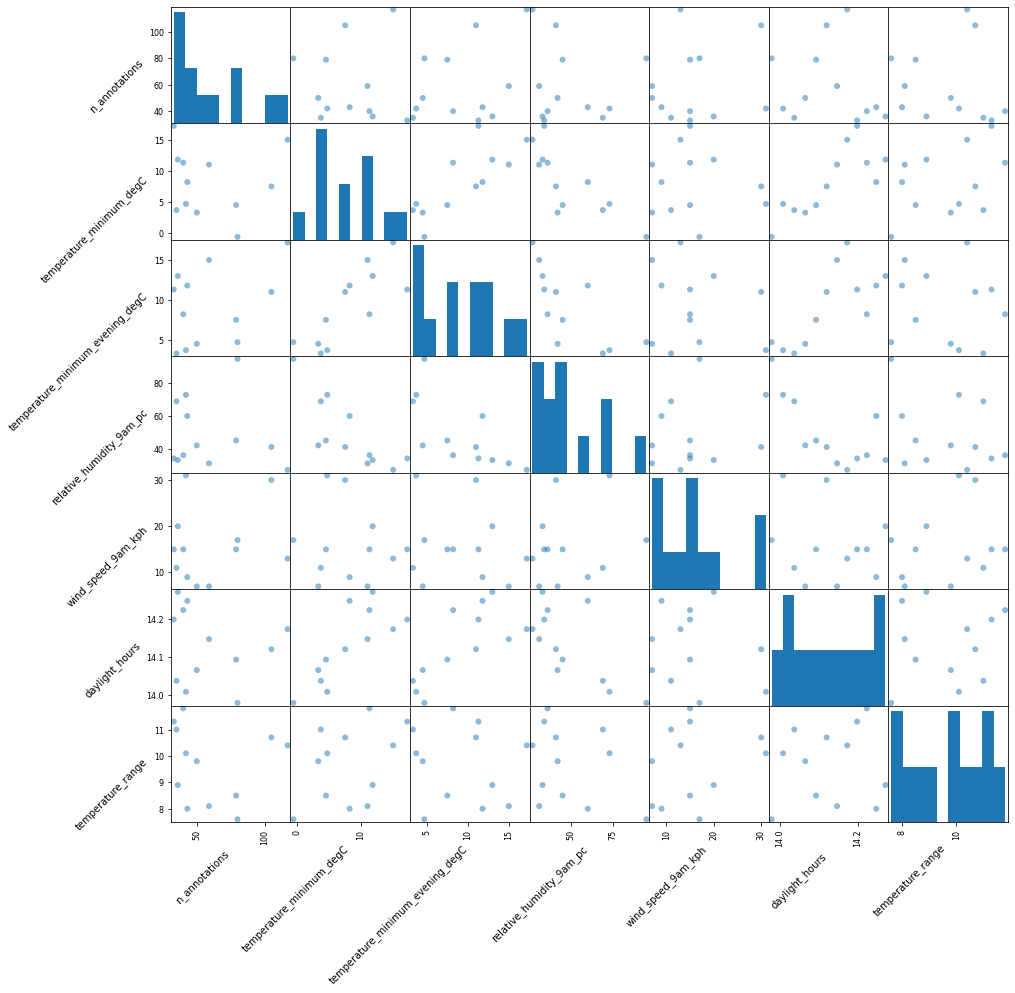

In [15]:
grr = pd.plotting.scatter_matrix(
    maelstrom_df[["n_annotations", *filtered_covariates]],
    marker="o",
    figsize=(15, 15),
)
for ax in grr[-1, :]:
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha="right")
for ax in grr[:, 0]:
    ax.set_ylabel(ax.get_ylabel(), rotation=45, ha="right")

Fitting a Poisson GLM of `n_annotations` vs. each covariate individually, and plotting the effect:

Significant single-effect variables:
  - temperature_range
  - daylight_hours
  - wind_speed_9am_kph
  - temperature_minimum_evening_degC


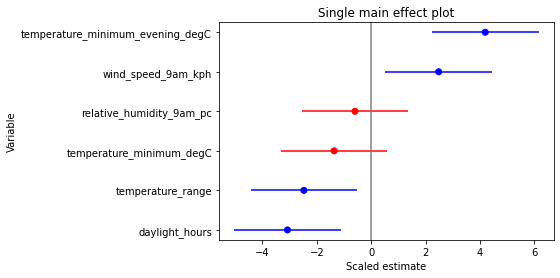

In [16]:
pois = sm.families.Poisson()

tvalues = []
pvalues = []
for covariate in filtered_covariates:
    mod = smf.glm(
        f"n_annotations ~ {covariate}",
        data=maelstrom_df,
        family=pois,
        exposure=maelstrom_df["exposures"],
    )
    res = mod.fit()
    tvalues.append(res.tvalues[1])
    pvalues.append(res.pvalues[1])
    
tvalues = np.array(tvalues)
pvalues = np.array(pvalues)

ordering = np.argsort(tvalues)
coloring = np.array(["r", "b"])[(pvalues[ordering] < 0.05).astype("u1")]

fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Single main effect plot",
    xlabel="Scaled estimate",
    ylabel="Variable",
)
ax.axvline(0, c="gray")
ax.hlines(
    np.array(filtered_covariates)[ordering],
    tvalues[ordering] - 1.96,
    tvalues[ordering] + 1.96,
    color=coloring
)
p = ax.scatter(
    tvalues[ordering],
    np.array(filtered_covariates)[ordering],
    color=coloring
)

significant_single_effect_variables = set(np.array(filtered_covariates)[pvalues < 0.05])
print("Significant single-effect variables:", *significant_single_effect_variables, sep="\n  - ")

Fitting a Poisson GLM of `n_annotations` vs. all of the covariates, and plotting the effect:

                 Generalized Linear Model Regression Results                  
Dep. Variable:          n_annotations   No. Observations:                   12
Model:                            GLM   Df Residuals:                        5
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.274
Date:                Sun, 01 Aug 2021   Deviance:                       24.473
Time:                        18:24:01   Pearson chi2:                     24.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

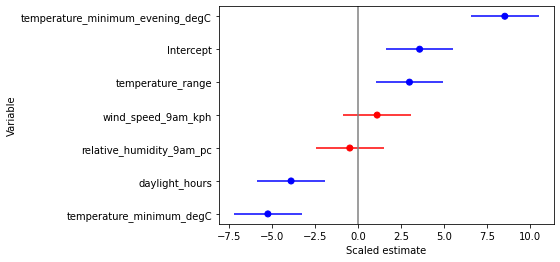

In [17]:
mod = smf.glm(
    "n_annotations ~ " + " + ".join(filtered_covariates),
    data=maelstrom_df,
    family=pois,
    exposure=maelstrom_df["exposures"],
)
res = mod.fit()
print(res.summary())
print(f"res.aic={res.aic}")

ordering = np.argsort(res.tvalues)
coloring = np.array(["r", "b"])[
    (res.pvalues[ordering] < 0.05).astype("u1")
]

fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Scaled estimate",
    ylabel="Variable",
)
ax.axvline(0, c="gray")
ax.hlines(
    res.tvalues.index[ordering],
    res.tvalues[ordering] - 1.96,
    res.tvalues[ordering] + 1.96,
    color=coloring,
)
p = ax.scatter(res.tvalues[ordering], res.tvalues.index[ordering], color=coloring)

significant_mixed_effect_variables = set(res.tvalues.index[res.pvalues < 0.05])

print("\nSignificant mixed-effect variables:", *significant_mixed_effect_variables, sep="\n  - ")

From the above plot, we can see that some of the variables do not have a significant effect on "n_annotations". So let's remove them and see if we get a better model.

                 Generalized Linear Model Regression Results                  
Dep. Variable:          n_annotations   No. Observations:                   12
Model:                            GLM   Df Residuals:                        7
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.915
Date:                Sun, 01 Aug 2021   Deviance:                       25.756
Time:                        18:24:01   Pearson chi2:                     25.3
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

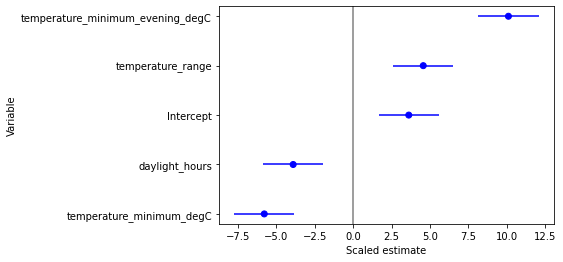

In [18]:
sig_eff_variables = list(significant_mixed_effect_variables - {"Intercept"})

mod = smf.glm(
    "n_annotations ~ " + " + ".join(sig_eff_variables),
    data=maelstrom_df,
    family=pois,
    exposure=maelstrom_df["exposures"],
)
res = mod.fit()
print(res.summary())
print(f"res.aic={res.aic}")

ordering = np.argsort(res.tvalues)
coloring = np.array(["r", "b"])[
    (res.pvalues[ordering] < 0.05).astype("u1")
]

fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Scaled estimate",
    ylabel="Variable",
)
ax.axvline(0, c="gray")
ax.hlines(
    res.tvalues.index[ordering],
    res.tvalues[ordering] - 1.96,
    res.tvalues[ordering] + 1.96,
    color=coloring,
)
p = ax.scatter(res.tvalues[ordering], res.tvalues.index[ordering], color=coloring)

Removing the variables from the model lowered AIC, meaning that not much information was lost, while reducing the risk of overfitting. We will proceed with this model.

To check that nothing strange is going on, we can plot the residuals:

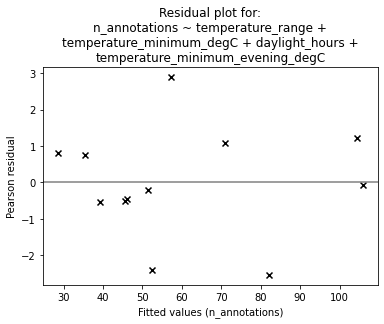

In [19]:
fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Residual plot for:\n" + "\n".join(textwrap.wrap(mod.formula, width=55)),
    ylabel="Pearson residual",
    xlabel="Fitted values (n_annotations)",
)

ax.axhline(0, c="gray")
p = ax.scatter(res.fittedvalues, res.resid_pearson, marker="x", c="k")

Finally, we can combine the summary abundance/activity plots from above, this time including the predicted values for "n_annotations" (and confidence interval) into the maelstrom plot.

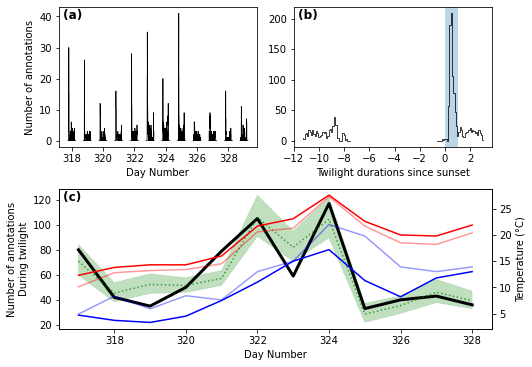

In [20]:
prediction = res.get_prediction()

# Set up figure
fig = plt.figure(
    figsize=(7.5, 5.2),
    tight_layout=True,
)
title_y = 0.87
title_fontdict = {"fontweight": "bold"}

# Define each subplot
# General summary plot
ax1 = fig.add_subplot(
    221,
    xlabel="Day Number",
    ylabel="Number of annotations",
)
ax1.set_title(
    " (a)", fontdict=title_fontdict, loc="left", y=title_y
)
# Twilight plot
ax2 = fig.add_subplot(
    222,
    xlabel="Twilight durations since sunset",
)
ax2.set_title(
    " (b)", fontdict=title_fontdict, loc="left", y=title_y
)
# Maelstrom plot with temperatures
ax3 = fig.add_subplot(
    212,
    xlabel="Day Number",
    ylabel="Number of annotations\nDuring twilight",    
)
ax3.set_title(
    " (c)", fontdict=title_fontdict, loc="left", y=title_y
)

# Actual plotting
# General summary plot
plot_activity_levels_summary(
    df,
    ax1,
    x_column="daynumber",
    bin_width=10 / 1440,   # 10 minutes
    c="k",
    lw=0.75,
)

# Twilight plot
plot_activity_levels_summary(
    df,
    ax2,
    x_column="within_twilight",
    bin_width=0.1,   # 10th of twilight duration
    c="k",
    lw=0.75,
)
twilight_vspan = ax2.axvspan(
    0, 1, alpha=0.3, label="Evening twilight"
)

# Maelstrom plot with temperatures
plot_maelstroms_with_temperature(
    maelstrom_df,
    ax3,
    maelstrom_kwargs=dict(
        c="k",
        lw=3,
    ),
)

# Model prediction
ax3.plot(
    maelstrom_df["daynumber"],
    prediction.predicted_mean * maelstrom_df["exposures"],
    color="g",
    alpha=0.7,
    linestyle="dotted",
)
conf_int = prediction.conf_int()
ax3.fill_between(
    maelstrom_df["daynumber"],
    conf_int[:, 0] * maelstrom_df["exposures"],
    conf_int[:, 1] * maelstrom_df["exposures"],
    color="g",
    alpha=0.25,
    linestyle="dotted",
)

# Force x-axis ticks to be integers to make it prettier
for ax in fig.axes:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [21]:
fig.savefig("activity_levels_figure.pdf", dpi=600.0, pad_inches=0.0)